In [65]:
import re
import random
import pandas as pd
import hashlib

In [66]:
with open("certcards2.txt", mode="r", encoding="utf8") as f:
    all_cards = f.read()

card_split_pattern = r"\n\n\n\d+\n"
all_cards = re.split(card_split_pattern, all_cards)
# Use re.DOTALL to allow . to match newline characters
card_pattern = re.compile(r"(.+?)\n([\s\S]+)", re.DOTALL)
cards = [
    (match.group(1), match.group(2))
    for cstring in all_cards
    if (match := re.search(card_pattern, cstring))
]

# removing the cards that have no content and trimming
cards = [
    (subject, stripped_content)
    for subject, content in cards
    if len(stripped_content := content.strip()) > 5
]


def hash_string_md5(s):
    """
    Hashes a string using MD5 and returns a truncated hash for efficiency.

    Parameters:
    - s (str): The input string to hash.

    Returns:
    - str: The truncated hexadecimal hash string.
    """
    if pd.isnull(s):
        return None  # Handle NaN values gracefully
    return hashlib.md5(s.encode("utf-8")).hexdigest()


def remake_card_document(
    existing_cards: pd.DataFrame, filename: str = "certcards2.txt"
):
    with open(filename, mode="w", encoding="utf8") as f:
        i = 1
        for _, row in existing_cards.iterrows():
            f.write("\n" * 6)
            f.write(str(i) + "\n")
            f.write(row["head"] + "\n")
            f.write(row["body"])
            i += 1
    print(f"Cards found: {existing_cards.shape[0]}")
    print(f"Total card age: {abs(existing_cards['age'].sum()):.2f}")


existing_cards = pd.DataFrame(cards, columns=["head", "body"])


# existing_cards['age'] = [random.random() for _ in existing_cards.index]
existing_cards["hash"] = existing_cards["body"].apply(hash_string_md5)

card_ages = pd.read_json("card_ages.json")
card_ages = card_ages.drop_duplicates(subset=["hash"], keep="first")

cards_to_age = pd.merge(
    left=existing_cards,
    right=card_ages[["hash", "age"]],
    left_on="hash",
    right_on="hash",
    how="left",
)


cards_to_age["head"] = cards_to_age["head"].str.strip()

# remove headers I don't want anymore
undesired_headers = ["CCH Axcess"]
cards_to_age = cards_to_age.loc[~cards_to_age["head"].isin(undesired_headers), :].copy()

cards_to_age["age"] = cards_to_age["age"].fillna(0)

age_factor = 1.01
cards_to_age["age"] = cards_to_age["age"] * age_factor

cards_to_age["age"] = cards_to_age["age"] + [
    random.expovariate(0.5) for _ in cards_to_age.index
]
# cards_to_age['age'] = cards_to_age['age'] * [random.expovariate(1) for _ in cards_to_age.index]
if cards_to_age["age"].mean() > 80:
    cards_to_age["age"] = cards_to_age["age"] * [
        random.expovariate(1.3) for _ in cards_to_age.index
    ]

# Adding priority age growth to cards for upcoming certifications
priority_headers = [
    "Django", 
    "PnP PowerShell",
    "Python + Oauth2.0"
    ]
priority_cards_mask = cards_to_age["head"].isin(priority_headers)
cards_to_age.loc[priority_cards_mask, "age"] = (
    cards_to_age.loc[priority_cards_mask, "age"] * 1.075
)

cards_to_age = cards_to_age.drop_duplicates(subset=["hash"], keep="first")

cards_to_age["subject_mean_age"] = cards_to_age.groupby("head")["age"].transform("mean")
cards_to_age["subject_highest_age"] = cards_to_age.groupby("head")["age"].transform(
    "max"
)
cards_to_age["subject_age_sum"] = cards_to_age.groupby("head")["age"].transform("sum")
cards_to_age["head_random_roll"] = cards_to_age.groupby("head")["head"].transform(
    lambda x: random.random()
)
cards_to_age["head_count"] = cards_to_age.groupby("head")["head"].transform("count")


cards_to_age.sort_values("hash")[["age", "head", "hash"]].to_json(
    "card_ages.json", indent=2
)

existing_cards = cards_to_age

In [67]:
ave_order = ('age', 'mean')
sum_order = ('age', 'sum')

stats = existing_cards.groupby('head').agg({'age': ['sum', 'mean', 'max'], 'head': 'count'}).sort_values(ave_order)
stats.columns = stats.columns.to_flat_index()
stats.columns = ['_'.join(col).strip() for col in stats.columns]
stats.index.name = None
stats

,age_sum,age_mean,age_max,head_count
eDiscovery,333.887702,6.183106,16.200317,54
Ubuntu,162.192571,6.238176,15.124993,26
Network Terms,186.867587,12.457839,22.591762,15
"The Mines of the Behemoth, Shea",1068.676259,21.809720,40.057040,49
Exchange Online and Defender,1123.551614,28.809016,52.108517,39
Docker,1009.844040,32.575614,51.156443,31
SSH + SCP,1053.865438,36.340188,55.713271,29
GUI Docker Container,1002.233439,47.725402,67.471900,21
Linux,1552.285371,48.508918,69.642267,32
"Everything is Tuberculosis, Green",1191.448509,51.802109,73.792751,23


# Histogram

sum of ages: ~64093.27


<Axes: >

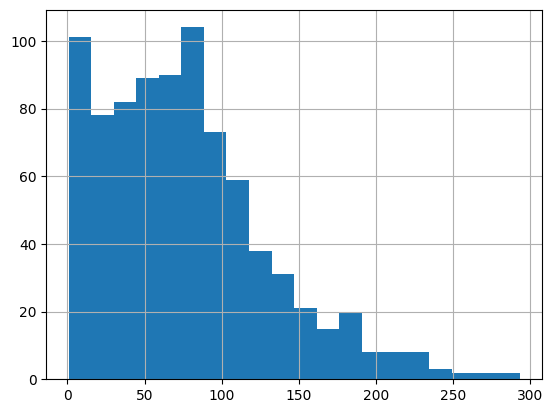

In [68]:
print(f"sum of ages: ~{existing_cards['age'].sum(0):.2f}")
existing_cards['age'].hist(bins=20)

sum of ages: ~64093.27


<Axes: >

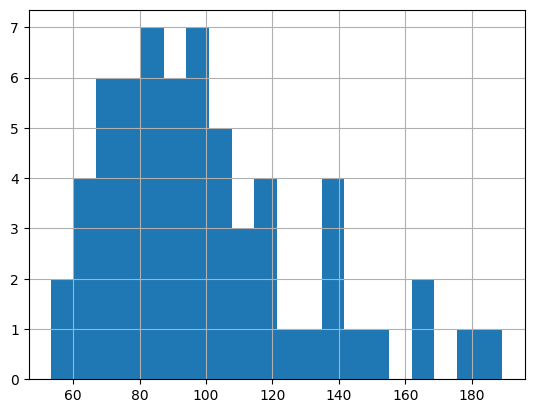

In [69]:
print(f"sum of ages: ~{existing_cards['age'].sum(0):.2f}")
existing_cards[existing_cards['head']=='Python']['age'].hist(bins=20)

# Completely Random Shuffle

In [70]:
# existing_cards = existing_cards.sample(frac=1)
# remake_card_document(filename='certcards2.txt', existing_cards = existing_cards)

# Age Sort

In [71]:
# existing_cards = existing_cards.sort_values('age', ascending=False)
# remake_card_document(filename='certcards2.txt', existing_cards=existing_cards)
# existing_cards.head(10)

# N-fold shuffle


## Age Sum

In [72]:
n = 3
m=existing_cards.shape[0]//100
existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
existing_cards['n_fold'] = existing_cards['count'] // m

existing_cards['subject_age_sum'] = existing_cards['subject_age_sum'] *-1
existing_cards['age'] = existing_cards['age'] *-1
existing_cards.sort_values(['n_fold', 'subject_age_sum', 'age'], inplace=True)

remake_card_document(existing_cards=existing_cards)
existing_cards.head(10)


Cards found: 834
Total card age: 64093.27


,head,body,hash,age,subject_mean_age,subject_highest_age,subject_age_sum,head_random_roll,head_count,count,n_fold
105,Python,Q:\nHow can you create an asynchronous generat...,e3fbc047653c230b6d83087c7accd3e0,-189.130074,100.058900,189.130074,-6203.651806,0.731296,62,0,0
392,Python,Q:\nWhat does an exit code of 0 typically sign...,6583ac672af8fe270936090feed600d6,-179.309622,100.058900,189.130074,-6203.651806,0.731296,62,1,0
670,Python,Q:\nHow can you raise an exception inside a ge...,e8a67cc29be602bfa76630ddade40494,-163.821477,100.058900,189.130074,-6203.651806,0.731296,62,2,0
106,Python,Q:\nHow do you make a custom object iterable?\...,642fdcdd1aca5eb88edcda4b9d62fa3d,-162.130574,100.058900,189.130074,-6203.651806,0.731296,62,3,0
393,Python,asyncio allows the creation of asynchronous ge...,3fafcded22215d307b5c7ee60c2c5186,-149.315301,100.058900,189.130074,-6203.651806,0.731296,62,4,0
671,Python,Front: What’s the quick “sys.path hack” to imp...,6780458541becad69eb5ed80c2bb1c2e,-145.218286,100.058900,189.130074,-6203.651806,0.731296,62,5,0
107,Python,Custom Logging Configuration\nUse logging.conf...,444fb1e4bc06a24ecbbd4bcde6799f93,-138.553651,100.058900,189.130074,-6203.651806,0.731296,62,6,0
394,Python,Q:\nWhich Python module provides an object-ori...,e0f21808be1ac9152eaecf47c5a28d93,-138.312268,100.058900,189.130074,-6203.651806,0.731296,62,7,0
74,Azure Files Documentation,Azure Files supports SMB Multichannel on SSD f...,5785b8c4140ac8f079157b1839fb35b1,-192.524546,101.481799,192.524546,-4972.608148,0.024172,49,0,0
363,Azure Files Documentation,If a client successfully authenticates to an i...,3023e4a433cfc5f642dd4e9f56065ebd,-185.350210,101.481799,192.524546,-4972.608148,0.024172,49,1,0


## Age Mean

In [73]:
# n=3
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] % n

# existing_cards['subject_mean_age'] = existing_cards['subject_mean_age'] *-1
# existing_cards['age'] = existing_cards['age'] *-1
# existing_cards.sort_values(['n_fold', 'subject_mean_age', 'age'], inplace=True)
# remake_card_document(existing_cards=existing_cards)

# existing_cards.head(10)

## Age Max

In [74]:
# n = random.choice([2, 3, 3, 4, 4, 5])

# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] // n

# if existing_cards['age'].sum() > 0:
#     existing_cards['subject_highest_age'] = existing_cards['subject_highest_age'] *-1
#     existing_cards['neg_age'] = existing_cards['age'] *-1
# existing_cards.sort_values(['n_fold', 'subject_highest_age', 'neg_age'], inplace=True)
# # existing_cards.sort_values(['age'], inplace=True)

# remake_card_document(existing_cards=existing_cards)
# existing_cards.head(10)


## Card Count

In [75]:
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()

# choices = ['floor', 'mod']
# option = random.choice(choices)
# if option == 'floor':
#     n=5
#     existing_cards['n_fold'] = existing_cards['count'] // n
#     print("floor dividing for n-fold")
# elif option == 'mod':
#     n=3
#     existing_cards['n_fold'] = existing_cards['count'] % n
#     print("modulo for n-fold")
# else: raise NotImplementedError


# if existing_cards['age'].sum() > 0:
#     # existing_cards['neg_subject_highest_age'] = existing_cards['subject_highest_age'] *-1
#     existing_cards['neg_age'] = existing_cards['age'] *-1
#     existing_cards['subject_highest_age'] *= -1
# existing_cards.sort_values(['n_fold', 'head_count', 'subject_highest_age', 'neg_age'], inplace=True)
# remake_card_document(existing_cards=existing_cards)

# existing_cards.head(10)


## Random

In [76]:
# n = 3
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] % n
# existing_cards['age'] *= -1
# existing_cards.sort_values(['n_fold', 'head_random_roll', 'age'], inplace=True)
# remake_card_document(existing_cards=existing_cards)
# existing_cards.head(10)

In [77]:
existing_cards.head(10)['age'].sum()

np.float64(-1643.6660076029539)

In [78]:
asc = existing_cards.age.sum() < 0

existing_cards.sort_values('age', ascending=asc).head(10)

,head,body,hash,age,subject_mean_age,subject_highest_age,subject_age_sum,head_random_roll,head_count,count,n_fold
1,Python + Oauth2.0,authorize_url\n\nThe endpoint where the user i...,6a264f45c613880c60d7986e3d683448,-293.355484,147.164419,293.355484,-2796.123969,0.971382,19,0,0
292,Python + Oauth2.0,"(""localhost"", 8080)\n\nThe address tuple passe...",d33808d12096e5298b1e5c8617c745a4,-292.272721,147.164419,293.355484,-2796.123969,0.971382,19,1,0
574,Python + Oauth2.0,handler.end_headers()\n\nFinalizes the HTTP re...,91ad05cd6046d3375013aa16d642650d,-274.206120,147.164419,293.355484,-2796.123969,0.971382,19,2,0
20,Terraform Codebox,Lifecycle blocks let you fine-tune resource be...,0f442d63063c2560ae76af631c6b9d12,-274.115772,126.983372,274.115772,-4444.418021,0.738527,35,0,0
280,Django,"Static Files\nCSS, JavaScript, and images that...",76729ae376ec4144e681846ea2579ff9,-254.446802,168.138456,254.446802,-4035.322934,0.287843,24,0,0
47,CCH Tax Forms Project,Disabling GenerateMeta in CCH Axcess export op...,0881e21379d3a9f0ad63b7c4f20a58f9,-254.020936,122.427155,254.020936,-2081.261629,0.819843,17,0,0
563,Django,Startup Command\nCommand App Service runs to s...,83f4640a04b8cff2171046cc02eb31c4,-246.657386,168.138456,254.446802,-4035.322934,0.287843,24,1,0
2,Python + Oauth2.0,socketserver.TCPServer\n\nA Python class that ...,f9eb8e3afe3c6b6d2051a4e85dae37ab,-243.373454,147.164419,293.355484,-2796.123969,0.971382,19,3,0
32,Power BI,Q: What is VertiPaq and why is it relevant whe...,2a90a97bd1a8825e67d41156094bdac0,-234.894175,126.109671,234.894175,-1261.096709,0.704249,10,0,0
8,JavaScript Concepts,"Yarn: An alternative package manager to npm, o...",70273b4e931be2d99e6061559bdf2f39,-233.530398,134.451533,233.530398,-4840.255193,0.235551,36,0,0


In [79]:
f"Average age: {abs(existing_cards['age'].mean()):.3f}"

'Average age: 76.850'